In [1]:
import datetime

from nltk.app.nemo_app import colors
from tensorflow import keras
from matplotlib import pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import PIL
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.data import AUTOTUNE
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.applications.densenet import layers
import pandas as pd
from tensorflow.python.keras.layers import Conv2D
from sklearn.metrics import precision_recall_fscore_support as score

BINARY_METRICS = [
    'accuracy',
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

BINARY_LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)

2021-12-12 22:46:40.232098: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_binary_data():
    data_dir = pathlib.Path('../dataset/binary_tf')

    image_count = len(list(data_dir.glob('*/*.jpg')))
    print('total images')
    print(image_count)

    no_tumor_length = len(list(data_dir.glob('no_tumor/*')))
    print(no_tumor_length)

    tumor_length = len(list(data_dir.glob('tumor/*')))
    print(tumor_length)

    batch_size = 32
    img_height = 512
    img_width = 512

    train_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=batch_size)

    val_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=batch_size)

    # plt.figure(figsize=(10, 10))
    # for images, labels in train_ds.take(1):
    #     for i in range(9):
    #         print('should plot')
    #         ax = plt.subplot(3, 3, i + 1)
    #         plt.imshow(images[i].numpy().astype("uint8"))
    #         plt.title(class_names[labels[i]])
    #         plt.axis("off")
    #
    # plt.show()
    return train_ds, val_ds

In [3]:
def class_weights_binary(class_names):
    df = pd.read_csv('../dataset/label.csv')
    counts = df['label'].value_counts().to_dict()
    return {class_names.index('no_tumor'): counts.get('no_tumor'),
            1 - class_names.index('no_tumor'): df.shape[0] - counts.get('no_tumor')}

In [19]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.figure(figsize=(8, 8))
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

    plt.show()


In [6]:
train_ds, val_ds = load_binary_data()
class_names = train_ds.class_names

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(512, 512, 1)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=BINARY_LOSS,
              metrics=BINARY_METRICS)

model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback],
    class_weight=class_weights_binary(class_names)
)

total images
3000
454
2546
Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D

2021-12-12 22:48:40.055603: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-12 22:48:40.055621: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-12 22:48:40.055683: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-12 22:48:40.146311: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


 1/75 [..............................] - ETA: 28:17 - loss: 1560.0680 - accuracy: 0.3125 - tp: 5.0000 - fp: 0.0000e+00 - tn: 5.0000 - fn: 22.0000 - precision: 1.0000 - recall: 0.1852 - prc: 0.9331

2021-12-12 22:49:03.290939: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-12 22:49:03.290980: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/75 [..............................] - ETA: 9:19 - loss: 1283.8792 - accuracy: 0.4531 - tp: 19.0000 - fp: 2.0000 - tn: 5.0000 - fn: 22.0000 - precision: 0.9459 - recall: 0.3926 - prc: 0.8888    

2021-12-12 22:49:10.811083: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-12 22:49:10.824756: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-12 22:49:10.840497: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20211212-224840/train/plugins/profile/2021_12_12_22_49_10
2021-12-12 22:49:10.863744: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20211212-224840/train/plugins/profile/2021_12_12_22_49_10/Josss-MBP.trace.json.gz
2021-12-12 22:49:10.939014: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20211212-224840/train/plugins/profile/2021_12_12_22_49_10
2021-12-12 22:49:10.939503: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20211212-224840/train/plugins/profile/2021_12_12

75/75 [==============================] - 611s 8s/step - loss: 411.5937 - accuracy: 0.8271 - tp: 1032.8026 - fp: 171.5000 - tn: 5.0263 - fn: 22.2500 - precision: 0.8663 - recall: 0.9483 - prc: 0.8570 - val_loss: 0.3685 - val_accuracy: 0.8500 - val_tp: 505.0000 - val_fp: 90.0000 - val_tn: 5.0000 - val_fn: 0.0000e+00 - val_precision: 0.8487 - val_recall: 1.0000 - val_prc: 0.9875
Epoch 2/20
75/75 [==============================] - 645s 9s/step - loss: 190.4501 - accuracy: 0.8782 - tp: 1046.9605 - fp: 145.0921 - tn: 35.9211 - fn: 3.6053 - precision: 0.8778 - recall: 0.9968 - prc: 0.9812 - val_loss: 0.3354 - val_accuracy: 0.8633 - val_tp: 505.0000 - val_fp: 82.0000 - val_tn: 13.0000 - val_fn: 0.0000e+00 - val_precision: 0.8603 - val_recall: 1.0000 - val_prc: 0.9914
Epoch 3/20
75/75 [==============================] - 653s 9s/step - loss: 146.5045 - accuracy: 0.8937 - tp: 1039.7237 - fp: 117.7895 - tn: 71.3553 - fn: 2.7105 - precision: 0.8904 - recall: 0.9979 - prc: 0.9910 - val_loss: 0.3190 -

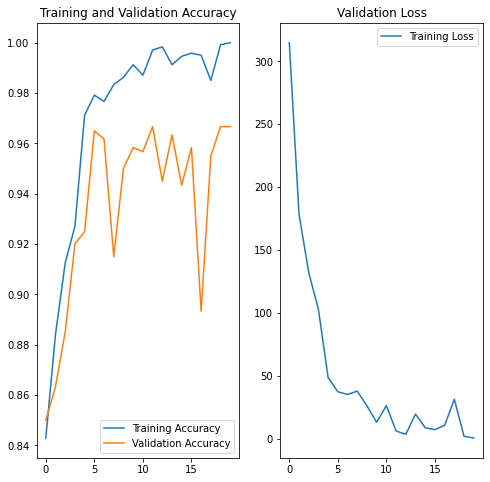

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


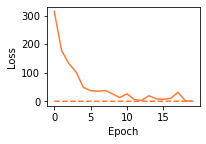

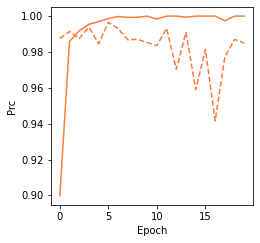

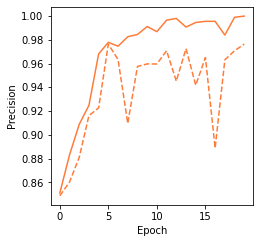

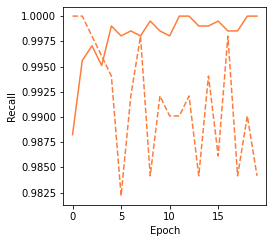

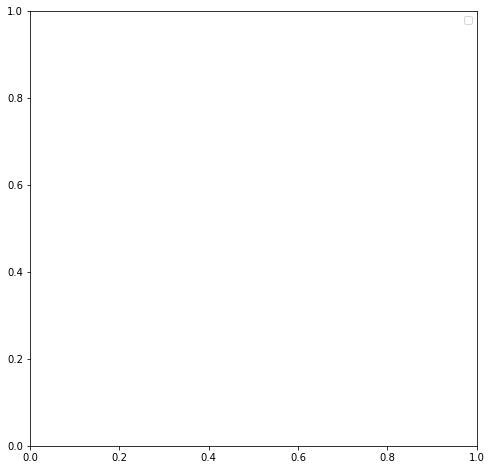

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

plot_metrics(history)